# Data Science & Business Analytics Intern at The Sparks Foundation - GRIP APRIL'21 Batch
### Author: Sumit Mishra

##  TASK 4: Detection of face mask (Domain: Computer Vision & Internet of Things)

### Implement a real time face mask detector.

### First Cut Approach

* We'll try to implement a model to detect whether person is weraring a face mask or not from both images and video streams.

### 1. Importing the required header files

In [1]:
#importing the required packages
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt

import imutils
from imutils import paths
from imutils.video import VideoStream
from google.colab.patches import cv2_imshow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
from google.colab import files
from tqdm import tqdm

### 2. Reading the data

In [ ]:
#Source of the data: https://github.com/prajnasb/observations/tree/master/experiements/data

#Getting all images from directory and loading images and storing it with its class label
imagePaths = list(paths.list_images('dataset'))
data, labels = [], []

for path in imagePaths:
	#Extracting the class label from the filename
	label = path.split(os.path.sep)[-2]
	#Loading the input image with size of 224 x 224
	image = load_img(path, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	#Storing it in a list
	data.append(image)
	labels.append(label)

#Converting the data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

### 3. Processing the data

In [ ]:
#Doing one-hot encoding on the class labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
#Splitting the data into train and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [ ]:
#Creating image data generator and doing some data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### 4. Loading pre-trained models and training the new model on top of it for predicting the confidence score of person wearing mask or not 

In [ ]:
#Loading the pre-trained MobileNetV2 network by excluding the top fully connected layers
#MobileNet-v2 is a convolutional neural network that is 53 layers deep.
#We have loaded a pretrained version of the network trained on more than a million images from the ImageNet database.
#The pretrained network can classify images into multple object categories.

mobnet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#Constructing the head of the model that will be placed on top of the the base model mobnet

head_mobnet = mobnet.output
#Average pooling layer with pool size of (7,7)
head_mobnet = AveragePooling2D(pool_size=(7, 7))(head_mobnet)
#Flattening the layer
head_mobnet = Flatten(name="flatten")(head_mobnet)
#FC dense layer with activation as relu
head_mobnet = Dense(128, activation="relu")(head_mobnet)
#Adding dropout to avoid overfitting
head_mobnet = Dropout(0.5)(head_mobnet)
#FC dense layer which will return the class probabilities
head_mobnet = Dense(2, activation="softmax")(head_mobnet)

model = Model(inputs=mobnet.input, outputs=head_mobnet)

#Setting all layers of mobet as False so so they will not be updated during the first training process
for layer in mobnet.layers:
	layer.trainable = False

In [ ]:
#Declaring callbacks
earlystopping = EarlyStopping(monitor='val_loss', patience=3)
#Compiling the model
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-4, decay=1e-4 / 25), metrics=["accuracy"])
#Fitting the model
history = model.fit(aug.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(x_train) // 32,
          validation_data=(x_test, y_test), validation_steps=len(x_test) // 32, epochs=25, callbacks=[earlystopping])

Epoch 1/25
34/34 [==============================] - 18s 440ms/step - loss: 0.5691 - accuracy: 0.7522 - val_loss: 0.2187 - val_accuracy: 0.9928
Epoch 2/25
34/34 [==============================] - 14s 405ms/step - loss: 0.2381 - accuracy: 0.9488 - val_loss: 0.0894 - val_accuracy: 1.0000
Epoch 3/25
34/34 [==============================] - 13s 395ms/step - loss: 0.1112 - accuracy: 0.9842 - val_loss: 0.0489 - val_accuracy: 1.0000
Epoch 4/25
34/34 [==============================] - 14s 403ms/step - loss: 0.0876 - accuracy: 0.9855 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 5/25
34/34 [==============================] - 14s 396ms/step - loss: 0.0574 - accuracy: 0.9895 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 6/25
34/34 [==============================] - 13s 396ms/step - loss: 0.0536 - accuracy: 0.9859 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 7/25
34/34 [==============================] - 13s 395ms/step - loss: 0.0636 - accuracy: 0.9885 - val_loss: 0.0178 - val_accuracy: 1.0000

### 5. Evaluating the trained model

In [ ]:
#prediction on test set
pred = model.predict(x_test, batch_size=32)

#Find the index of the label with corresponding largest predicted probability
pred = np.argmax(pred, axis=1)

#classification report
print(classification_report(y_test.argmax(axis=1), pred, target_names=lb.classes_))

              precision    recall  f1-score   support

          no       1.00      0.99      1.00       138
         yes       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



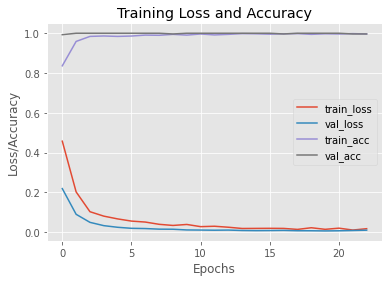

In [ ]:
#Plotting the train/test loss & accuracy
N = history.epoch[-1] + 1
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()

In [ ]:
#Saving the model
model.save('saved_model.hdf5')

### 6. Face mask detection in an image

In [45]:
#Loading pre-trained face detector model from disk
prototxtPath = "face_detector/deploy.prototxt"
weightsPath = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
#Loading the face mask detector model
model = load_model('saved_model.hdf5')

In [46]:
def detect_mask(input_img):
  '''
  This function takes image path as an input and predicts whether face is wearing mask or not
  '''
  #Loading the image
  if type(input_img) == str:
    image = cv2.imread(input_img)
  else:
    image = input_img
  orig = image.copy()
  (h, w) = image.shape[:2]

  #Constructing a blob from the image
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

  #Passing the blob through the network and obtaining the face detections
  net.setInput(blob)
  detections = net.forward()

  #Looping over the detections
  for i in range(0, detections.shape[2]):
	  #Extracting the confidence score associated with the detection
	  confidence = detections[0, 0, i, 2]
	  #Filtering the weak detections by ensuring the confidence is greater than the minimum confidence 0.5
	  if confidence > 0.5:
		  #Computing the (x, y) coordinates of the bounding box for the object
		  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		  (startX, startY, endX, endY) = box.astype("int")
		  #Ensuring the bounding boxes will fall within the dimensions of the frame
		  (startX, startY) = (max(0, startX), max(0, startY))
		  (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      #Converting image from BGR to RGB channel and resizing it to 224x224, and then preprocessing it
		  face = image[startY:endY, startX:endX]
		  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		  face = cv2.resize(face, (224, 224))
		  face = img_to_array(face)
		  face = preprocess_input(face)
		  face = np.expand_dims(face, axis=0)
		  #Passing the face through the model to determine if the face has a mask or not
		  (withoutMask, mask) = model.predict(face)[0]
		  label = "Mask" if mask > withoutMask else "No Mask"
		  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
		  #including the probability in the label
		  label = "{}({:.2f}%)".format(label, max(mask, withoutMask) * 100)
		  #Displaying the label and bounding box rectangle on the output frame
		  cv2.putText(image, label, (startX + 10, startY + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
		  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  return image

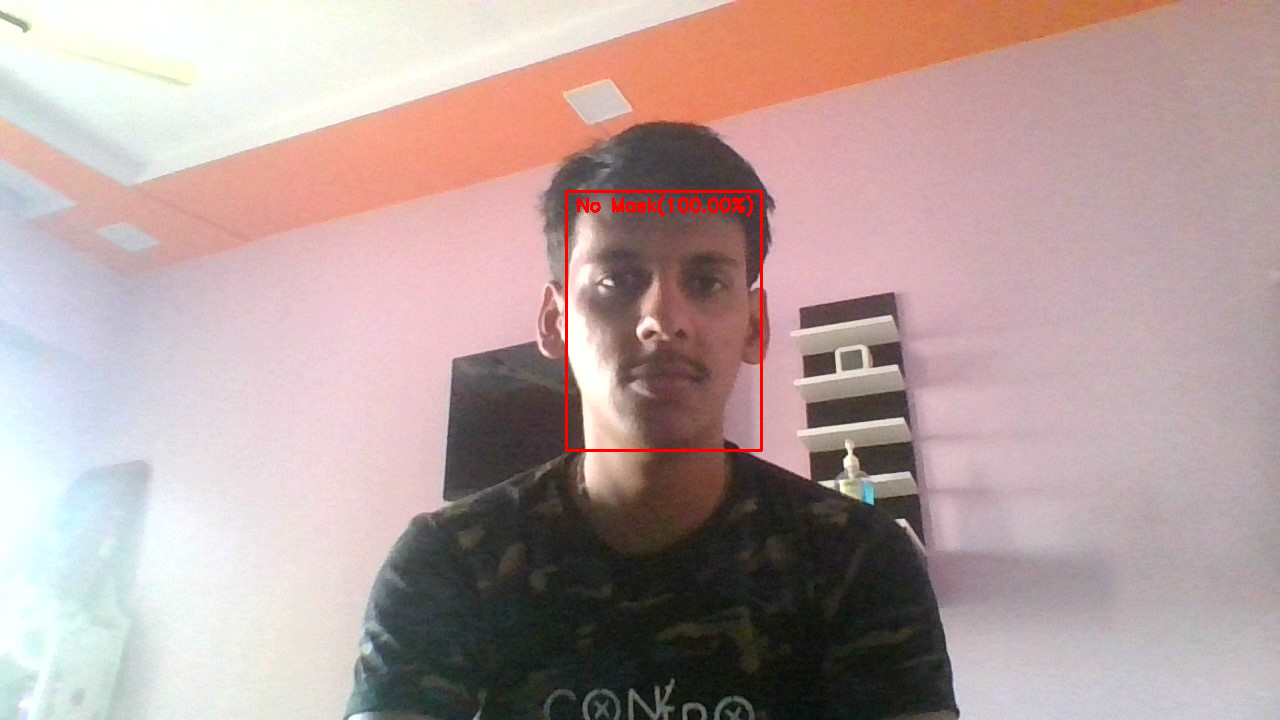

In [ ]:
#Testing with not wearing a mask image
cv2_imshow(detect_mask('/content/WIN_20210406_17_38_33_Pro.jpg'))

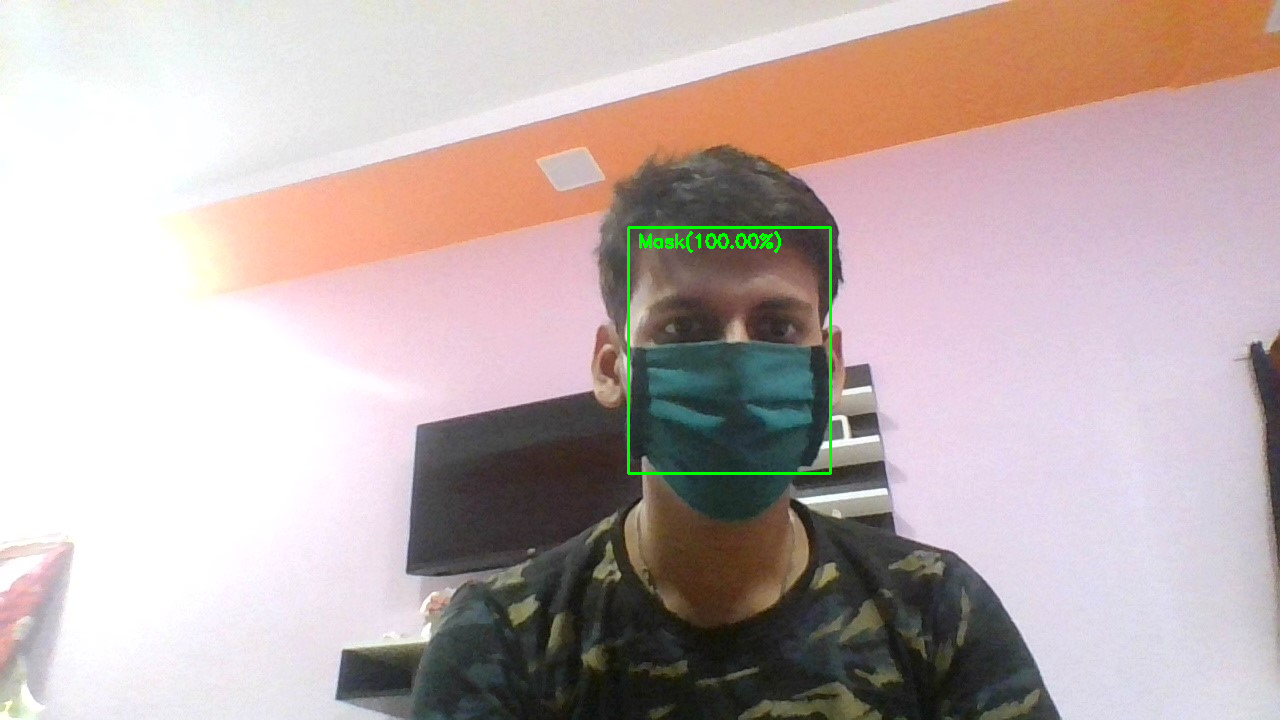

In [4]:
#Testing with wearing a mask image
cv2_imshow(detect_mask('/content/WIN_20210406_18_52_56_Pro.jpg'))

### 7. Face mask detection in video streams

In [36]:
def detect_mask_in_video():
  '''
  This function ask user to upload a video.
  Then each frames from that video are fetched and passed to detect_mask()
  which will detect whether person in that frame is wearing a mask or not
  with the confidence score of prediction.
  Then each detected frames are merged to create an output video.
  '''
  #Uploading a video(input)
  uploaded = files.upload()
  ext = list(uploaded.keys())[0].split('.')[-1]
  if ext not in ['avi','mp4','AVI','MP4']:
    print('Not a video! Please upload only video files.\n(Only avi and mp4 files are allowed.)')
  else:
    video_path = list(uploaded.keys())[0]
    print('Video uploaded successfully!!!')

  #Reading the video and creating image frames
  cam = cv2.VideoCapture(video_path)
  frames = []
  while(True):
	  #Reading from frame
	  ret,frame = cam.read()
	  if ret:
		  # writing the extracted images
		  frames.append(frame)
	  else:
		  break
  #Releasing all space and windows once done
  cam.release()
  cv2.destroyAllWindows()

  #Detecting mask or not mask for each frames of input video
  op_vid = []
  for i in frames:
    op_vid.append(detect_mask(i))

  #Writing frames to video
  out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (frames[0].shape[1],frames[0].shape[0]))
  for i in range(len(op_vid)):
      out.write(op_vid[i])
  out.release()

  print('Wearing a mask or not in video got saved as output.avi successfully!!!')

In [37]:
detect_mask_in_video()

Saving WIN_20210406_17_52_05_Pro.mp4 to WIN_20210406_17_52_05_Pro.mp4
Video uploaded successfully!!!
Wearing a mask or not in video got saved as output.avi successfully!!!


### 8. Conclusion

* We have collected the data from a github repository uploaded by Prajna Bhandary.
* We have used pre-trained MobilleNetV2 to predict whether in an image person is wearing a mask or not.
* Then we have created our own model architecture on top of MobileNetV2 model by keeping its training parameter as False.
* We are able to achieve more than 99% of train and test accuracy, which is actually quite very good.
* We have also used caffee and other face detector model to detect the face region in an image to plot bounding boxes on an image with confidence score of person wearing a mask or not.
* We did this with both image input and video streams.
* Now we can say, we have successfully built a model for face mask detection from an image or a video. 